# Polynomial Chaos: A technique for modeling uncertainty

### Emily Gorcenski
### @EmilyGorcenski

[Download talk at emilygorcenski.com/post/infoshare-2022](emilygorcenski.com/post/infoshare-2022)

### Content Notes

- A lot of math, including measure theory and advanced probability theory
- The cool stuff comes at the end


### Polynomial Chaos is a way of representing random variables/random processes in terms of orthogonal polynomials

- Can be thought of a special case of Kosambi-Karhunen-Loève
- Can equivalently be thought of as PCA over an orthogonal vector space of polynomials

#### KKL Transform
$X_t = \sum_{i=0}^\infty Z_i e_i(t)$

#### PCA
$X = \sum_{i=0}^N \langle \phi_i, X \rangle \phi_i$

#### Polynomial Chaos
$X = \sum_{i=0}^\infty X_i \Phi_i(\zeta)$

### Polynomial Chaos lets us represent annoying uncertainty in terms that we can control

- Allows for acceleration of Monte Carlo simulation
  - Shifts the burden from computing stochastic solutions to computing deterministic parameters
- Allows us to handle distributions without convenient forms
  - Good for generating synthetic data!

The Cameron-Martin theorem guarantees that the Polynomial Chaos representation converges to an $L^2$ functional in the $L^2$ sense: we can therefore use it to represent a random process belonging to any distribution with a finite second moment (aka finite variance).

Simpler Terms: We can represent random variables of arbitrary distributions using a Polynomial Chaos expansion about a random variable **of our choice**.

There exists a natural relationship between orthogonal polynomials and probability distributions.

Hermite Polynomials:

$$ \langle H_i(\zeta)\, H_j(\zeta) \rangle  = \int_{-\infty}^\infty H_i(\zeta) H_j(\zeta) \color{red}{e^{-\frac{\zeta^2}{2}}}\, d\zeta = \color{red}{\sqrt{2\pi}} i! \delta_{ij}$$

This looks very Gaussian! We can then use the Polynomial Chaos representation to write **any** finite-variance r.v. $k$ as a series of Hermite polynomials about a Gaussian r.v.

$$k = \sum_{i=0}^\infty k_i H_i(\zeta)$$

The $k_i$ are deterministic coefficients. We use the Galerkin projection to compute them:

$$k_i = \frac{\langle k H_i(\zeta) \rangle}{\langle H_i^2(\zeta) \rangle} = \frac{1}{\langle H_i^2 \rangle} \int_{-\infty}^\infty k H_i(\zeta) e^{-\frac{\zeta^2}{2}}\, d\zeta.$$

Let's use the fact that $k$ and $\zeta$ are fully dependent and perform an inverse sample transform.

Using the CDF of both random variables, transform them to the same **uniform** random variable supported on $[0,1]$.

$$u = G(\zeta) = F(k).$$

$$k = F^{-1}(u) \stackrel{\small{\textrm{def}}}{=} h(u),$$
$$\zeta = G^{-1}(u) \stackrel{\small{\textrm{def}}}{=} l(u).$$

Using this transform, the integral is transformed:

$$\int_{-\infty}^\infty k H_i(\zeta) e^{-\frac{\zeta^2}{2}}\, d\zeta \Longrightarrow \int_0^1 h(u) H_i(l(u))\, du$$

We can then compute the coefficients $k_i$ with a fairly basic integral:

$$k_i = \frac{1}{\langle H_i^2 \rangle}\int_0^1 h(u) H_i(l(u))\, du.$$

What about that inner product? Three options:

- Use the closed form representation from the orthogonality condition: $ \langle H_i^2(\zeta) \rangle = \sqrt{2\pi} i!$;
- Choose a scaling of $\zeta$ such that the orthogonality condition is just the Kronecker delta;
- Just compute the integral.

Option 2 is best, but tedious. So let's go with option three using a numerical integrator, e.g. the Trapezoidal method or Gaussian Quadrature.

Ok less words more code

Reminder: we want to compute $k_i$ so that we can assemble a random variable of an arbitrary distribution using Gaussian random variables with zero mean and standard deviation $1$ (aka standard normal):

$$k = \sum_{i=0}^\infty k_i H_i(\zeta)$$

In [2]:
import numpy as np
import numpy.polynomial.hermite_e as H
from scipy.stats import norm, ks_2samp, skew
from matplotlib import pyplot as plt
from IPython.display import display
from sdv.tabular import GaussianCopula, CTGAN, TVAE
import pandas as pd
%matplotlib inline

In [3]:
def Herm(n):
    coeffs = [0] * (n+1)
    coeffs[n] = 1
    return coeffs

# compute the inner product of hermite polynomials and return a function
# to evaluate this inner product at a point x
def inner_product(h1, h2):
    return lambda x: H.hermeval(x, H.hermemul(h1, h2))

# Use trapezoid integration to compute the integral of a function f
# over the support [a, b] using n partitions
def trapezoid_int(f, a, b, n=100):
    P = [a + i * (b - a) / n for i in range(0, n + 1)]
    F = [1 / 2 * np.abs(P[i+1] - P[i]) * (f(P[i+1]) + f(P[i])) for i in range(0, len(P)-1)]
    return sum(F)

In [4]:
# Define a handful of inverse cumulative distribution functions, from Wikipedia
def unif_icdf(params):
    a = params[0]
    b = params[1]
    return lambda u : u * (b - a) + a

def expo_icdf(params):
    return lambda u : -np.log(1-u)

def norm_icdf(params):
    return lambda u : norm.ppf(u, loc=0, scale=1)

In [5]:
def approximate_rv_coeffs(P, h):
    # initialize lists for output to make syntax more canonical with the math
    ki = [0] * P
    
    # Set up Gauss-Hermite quadrature
    m = P**2
    x, w = H.hermegauss(m)
    
    # Compute the coefficients, and also build out k in the same pass
    for i in range(0, P):
        # compute the inner product with numerical integration
        ip = sum([inner_product(Herm(i), Herm(i))(x[idx]) * w[idx] for idx in range(m)])
        # compute the integral
        integrand = lambda u : h(u) *  H.hermeval(norm.ppf(u, loc=0, scale=1), Herm(i))
        ki[i] = np.sqrt(2*np.pi) / ip * trapezoid_int(integrand, 0.001, 1-0.001, 1000)
    return ki

In [6]:
def generate_rv(ki, S):
    # build out k termwise
    return sum([ki[i] * H.hermeval(S, Herm(i)) for i in range(len(ki))])

In [7]:
# Generate a bunch of Gaussian random variables to use
N = 5000
S = np.random.normal(loc=0, scale=1, size=N)

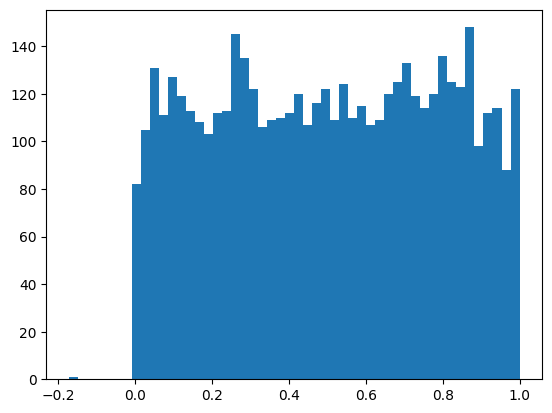

In [13]:
h = unif_icdf([0,1])
ki_uniform = approximate_rv_coeffs(13, h)
k = generate_rv(ki_uniform, S)
out = plt.hist(k, bins=50)

In [14]:
# what are the mean and standard deviation of a standard uniform distribution
# mean = 0.5
# std = 1 / √12 ~= 0.289

ki_uniform[:2]

[0.49900000000000033, 0.2787554508625054]

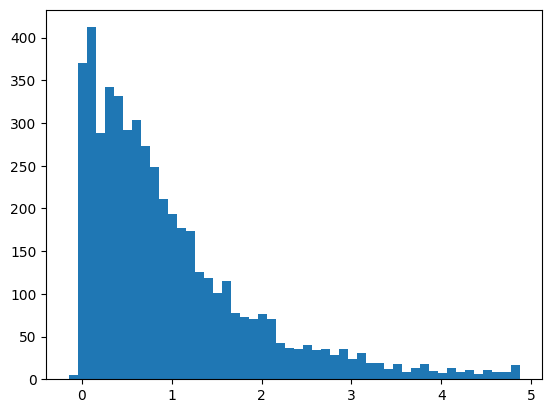

In [18]:
h = expo_icdf([])
ki_expo = approximate_rv_coeffs(9, h)
k_expo = generate_rv(ki_expo, S)
out = plt.hist(k_expo, bins=50)

### Must we use Gaussian random variables?

No! The Wiener-Askey scheme is rad.

|             | Distribution      | Family     | Support                |
|:------------|:------------------|:-----------|:-----------------------|
| Continuous  | Gaussian          | Hermite    | $(-\infty, \infty)$    |
|             | Uniform           | Legendre   | $[a,b]$                |
|             | Gamma             | Laguerre   | $[0,\infty)$           |
|             | Beta              | Jacobi     | $[a,b]$                |
| Discrete    | Poisson           | Charlier   | $\{0,1,\ldots\}$       |
|             | Negative Binomial | Miexner    | $\{0,1,\ldots\}$       |
|             | Binomial          | Krawtchouk | $\{0,1,\ldots\, N\}$   |
|             | Hypergeometric    | Hahn       | $\{0,1,\ldots\, N\}$   |

$$\langle \Phi_i(\zeta) \Phi_j(\zeta) \rangle = \int_S \Phi_i(\zeta) \Phi_j(\zeta) \color{red}{w(\zeta)\, d\zeta}$$

$$w(\zeta)\, d\zeta = \frac{d\mu}{d\zeta}d\zeta$$

Generalize to

$$\langle \Phi_i(\zeta) \Phi_j(\zeta) \rangle = \int_S \Phi_i(\zeta) \Phi_j(\zeta) d\mu \Longrightarrow \sum_{n\in S} \Phi_i\left(\zeta_n\right)\Phi_j\left(\zeta_n\right)w\left(\zeta_n\right)$$

### So let's have a practical example

Suppose we want to solve a differential equation:

$$\frac{dy(k; t)}{dt} = -ky(k; t).$$

In [19]:
# The basic RK4 ODE solver
def RK4(f, ic, tspan, h):
    t = [x * h for x in range(int((max(tspan) - min(tspan)) / h) + 1)]
    y = [ic]
    h2 = h / 2
    for i in range(0, len(t)-1):
        y1 = f(t[i], y[i])
        y2 = f(t[i] + h2, y[i] + np.multiply(h2, y1))
        y3 = f(t[i] + h2, y[i] + np.multiply(h2, y2))
        y4 = f(t[i] + h, y[i] + np.multiply(h, y3))
        y.append(y[i] + np.multiply(h/6, y1 + y4 + np.multiply(2, y2 + y3)))
    return t, y

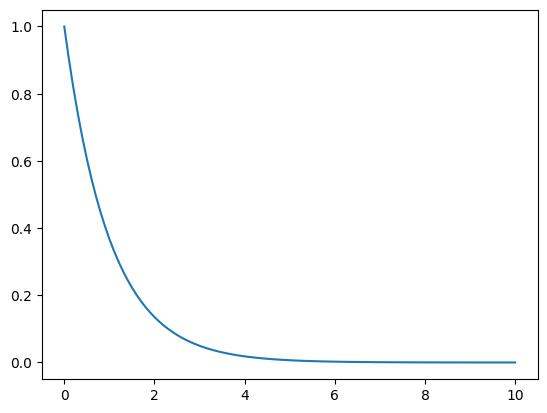

In [20]:
k = 1
A = np.matrix([[-k]])
ode = lambda t, x: A * x
ic = np.matrix([1])
t, y = RK4(ode, ic, [0, 10], .1)
y1 = [yt.item() for yt in y]
plt.plot(t, y1)

Now suppose we let $k$ be a random parameter with support $S$, pdf $f(k)$ and mean $\bar{k}$.

$$\bar{y}(t) = y_0 e^{-\bar{k}t}$$

$$\bar{y}(t) = y_0 \int_S f(k)e^{-kt}\, dk$$

We'll run a Monte Carlo simulation, $N = 1000$.

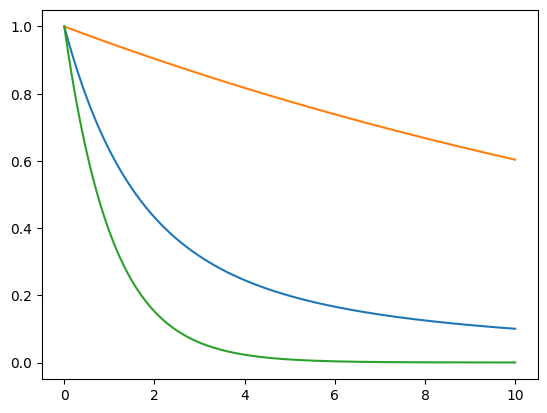

In [21]:
y_dmc = []
for idx in range(1000):
    k = -np.random.uniform(0,1)
    B = np.matrix([[k]])
    icb = np.matrix([1])
    odeb = lambda t, x: B * x
    t, y = RK4(odeb, icb, [0, 10], .01)
    y_dmc.append([yt.item() for yt in y])

plt.plot(t, np.mean(y_dmc, axis=0))
plt.plot(t, np.percentile(y_dmc, axis=0, q=95))
plt.plot(t, np.percentile(y_dmc, axis=0, q=5))
    

Important note! The mean solution is not the same as the solution for the mean of $k$.

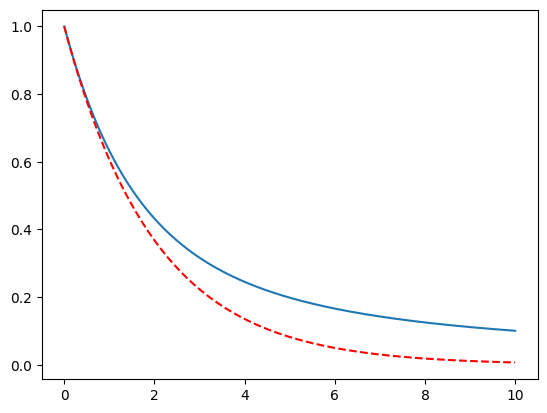

In [22]:
plt.plot(t, np.mean(y_dmc, axis=0))

B = np.matrix([[-0.5]])
icb = np.matrix([1])
odeb = lambda t, x: B * x
t, y = RK4(odeb, icb, [0, 10], .01)
y_detmean = [yt.item() for yt in y]
plt.plot(t, y_detmean, 'r--')

We can use Polynomial Chaos to make this easier.

$$k = \sum_{i=0}^P k_i \Phi_i(\zeta)$$
$$y(t) = \sum_{i=0}^P y_i(t) \Phi_i(\zeta)$$

$$\sum_{i=0}^P \frac{dy_i}{dt} \Phi_i(\zeta) = -\left(\sum_{i=0}^P k_i \Phi_i(\zeta)\right)\left(\sum_{i=0}^P y_i \Phi_i(\zeta)\right)$$

Perform the Galerkin projection and gather terms.

$$\frac{dy_l(t)}{dt} = -\frac{1}{\langle \Phi_l^2(\zeta)\rangle} \sum_{i=0}^P\sum_{j=0}^P \langle \Phi_i \Phi_j \Phi_j \rangle k_i y_j(t)$$

- $\langle \Phi_i \Phi_j \Phi_j \rangle$: This is easily computed with Gauss-Hermite quadrature
- $k_i$: We've already computed these!

Result: we have a single $P^{\text{th}}$-order linear ODE to solve!

In [23]:
def triple_product(h1, h2, h3):
    return lambda x : H.hermeval(x, H.hermemul(h1,
                                               H.hermemul(h2, h3)))

In [24]:
P = 5
A = np.matrix(np.zeros((P,P)))
m = P**3
x, w = H.hermegauss(m)

for l in range(P):
    ip = sum([inner_product(Herm(l), Herm(l))(x[idx]) * w[idx] for idx in range(m)])
    for j in range(P):
        for i in range(P):
            tp = sum([triple_product(Herm(i), Herm(j), Herm(l))(x[idx]) * w[idx] for idx in range(m)])
            A[l,j] += - 1 / ip * tp * ki_uniform[i]

ode = lambda t, x: A * x
ic = np.matrix(np.zeros((P,1)))
ic[0] = 1
t, y = RK4(ode, ic, [0, 10], .01)

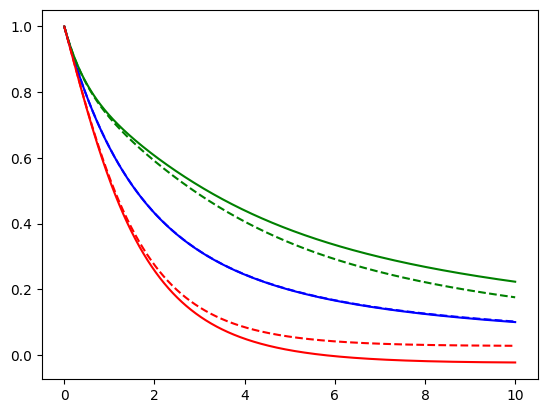

In [25]:
plt.plot(t, np.mean(y_dmc, axis=0), 'b-')
plt.plot(t, np.mean(y_dmc, axis=0)+3*np.var(y_dmc, axis=0), 'g-')
plt.plot(t, np.mean(y_dmc, axis=0)-3*np.var(y_dmc, axis=0), 'r-')

y_pc_mean = [x[0,0] for x in y]
y_pc_var = [x[1,0]**2 for x in y]
plt.plot(t, y_pc_mean, 'b--')
plt.plot(t, np.add(y_pc_mean, np.multiply(3, y_pc_var)), 'g--')
plt.plot(t, np.add(y_pc_mean, np.multiply(-3, y_pc_var)), 'r--')

In [ ]:
# y_pc = []
# for zeta in S[:500]:
#     y_pc.append([[H.hermeval(zeta, np.squeeze(x.tolist())) for i in range(P)] for x in y])

In [26]:
# let's generate the mean and confidence intervals for 
y_pc = [[[H.hermeval(zeta, np.squeeze(x.tolist())) for i in range(P)] for x in y] for zeta in S[:500]]

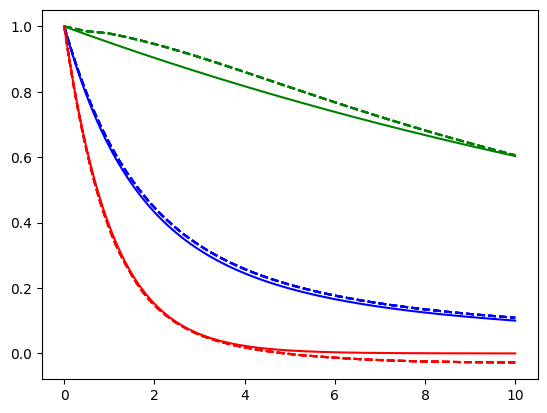

In [27]:
plt.plot(t, np.mean(y_dmc, axis=0), 'b-')
plt.plot(t, np.percentile(y_dmc, axis=0, q=95), 'g-')
plt.plot(t, np.percentile(y_dmc, axis=0, q=5), 'r-')
plt.plot(t,np.mean(y_pc, axis=0), 'b--')
plt.plot(t, np.percentile(y_pc, axis=0, q=95), 'g--')
plt.plot(t, np.percentile(y_pc, axis=0, q=5), 'r--')


Ok, but solving elementary differential equations isn't so useful. Let's do something a little more useful. How can we model arbitrary distributions?

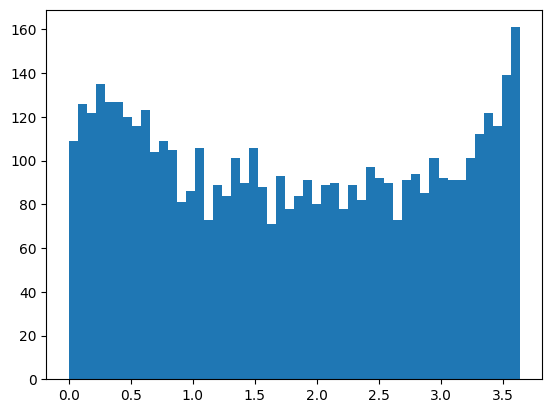

In [30]:
# Generate a bunch of Gaussian random variables to use
N = 5000
weird_function = lambda x : x**2 + np.exp(x)*np.sin(2*x) + 1/6.*np.sqrt(x)
weird = weird_function(np.sort(np.random.uniform(size=N)))
out = plt.hist(weird, bins=50)

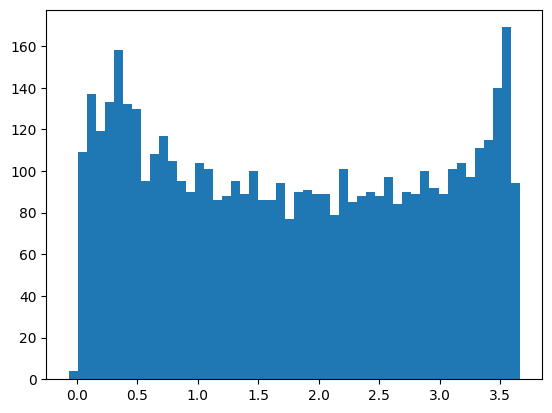

In [35]:
def basis(size, index):
    arr = np.zeros(size)
    arr[index] = 1.0
    return arr

order = 10
gaussian = np.sort(np.random.normal(loc=0, scale=1, size=N))
A = np.array([[H.hermeval(zeta, basis(order, idx)).item() for idx in range(order)] for zeta in gaussian])
m, _, _, _ = np.linalg.lstsq(A, weird, rcond=None)
out = plt.hist(H.hermeval(gaussian, m), bins=50)

Ok, but what about real world data?

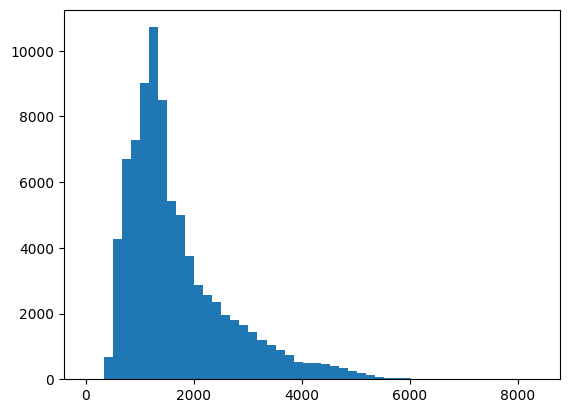

In [38]:
my_data = np.genfromtxt('transactions.csv', delimiter=',')
transactions = np.sort(my_data[1:,2])
out = plt.hist(transactions, bins=50)

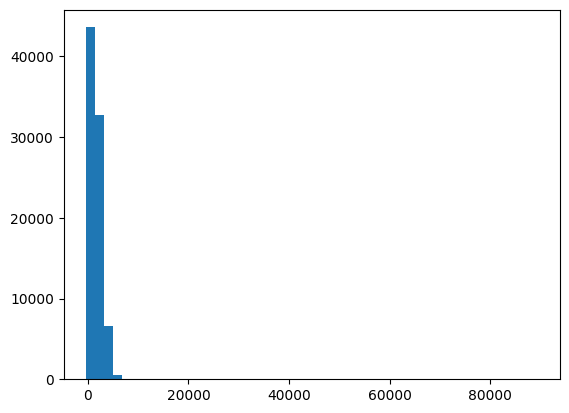

In [43]:
order = 15
N = np.size(transactions)
gaussian = np.sort(np.random.normal(loc=0, scale=1, size=N))
A = np.array([[H.hermeval(zeta, basis(order, idx)).item() for idx in range(order)] for zeta in gaussian])
m, _, _, _ = np.linalg.lstsq(A, transactions, rcond=None)
new_gaussian = np.sort(np.random.normal(loc=0, scale=1, size=N))
out = plt.hist(H.hermeval(new_gaussian, m), bins=50)

In [40]:
ks_2samp(transactions, H.hermeval(new_gaussian, m), mode="exact")

KstestResult(statistic=0.011199214258336528, pvalue=5.6669504262093706e-05)

In [44]:
{
    "sample": {
        "mean": np.mean(transactions),
        "std": np.std(transactions)
    },
    "gPC":{
        "mean": m[0],
        "std": m[1]
    }
}

{'sample': {'mean': 1694.6021583940208, 'std': 963.2808744868768},
 'gPC': {'mean': 1700.760590737025, 'std': 896.8284722705672}}

/Users/emilygorcenski/talks/infoshare-2022/env/lib/python3.9/site-packages/ctgan/data_transformer.py:188: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1] = np.argmax(column_data[:, 1:], axis=1)


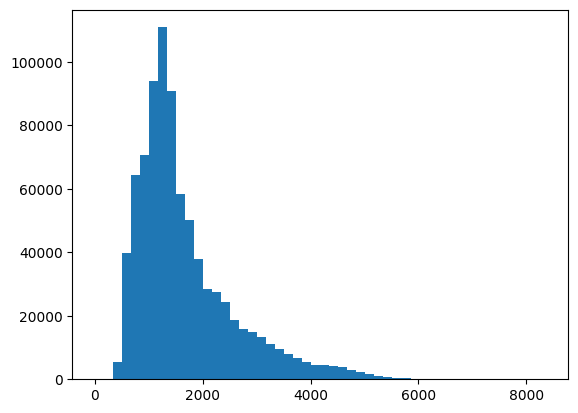

In [47]:
df = pd.read_csv("transactions.csv")
df.drop(columns=['date', 'store_nbr'], inplace=True)
model = TVAE()
model.fit(df)
sdv_data = model.sample(10*N)['transactions']
out = plt.hist(sdv_data, bins=50)

In [46]:
{
    "sample": {
        "mean": np.mean(transactions),
        "std": np.std(transactions)
    },
    "gPC": {
        "mean": m[0],
        "std": m[1]
    },
    "sdv": {
        "mean": np.mean(sdv_data),
        "std": np.std(sdv_data)
    }
}

{'sample': {'mean': 1694.6021583940208, 'std': 963.2808744868768},
 'gPC': {'mean': 1700.760590737025, 'std': 896.8284722705672},
 'sdv': {'mean': 1694.2684996646224, 'std': 962.7901250011341}}